Epoch 1/300
79/79 [==============================] - 5s 15ms/step - loss: 2.6602 - accuracy: 0.2752
Epoch 2/300
79/79 [==============================] - 1s 11ms/step - loss: 1.6585 - accuracy: 0.3808
Epoch 3/300
79/79 [==============================] - 1s 11ms/step - loss: 1.4270 - accuracy: 0.4580
Epoch 4/300
79/79 [==============================] - 1s 11ms/step - loss: 1.2464 - accuracy: 0.5112
Epoch 5/300
79/79 [==============================] - 1s 11ms/step - loss: 1.1484 - accuracy: 0.5516
Epoch 6/300
79/79 [==============================] - 1s 11ms/step - loss: 1.0167 - accuracy: 0.6104
Epoch 7/300
79/79 [==============================] - 1s 11ms/step - loss: 0.9304 - accuracy: 0.6368
Epoch 8/300
79/79 [==============================] - 1s 11ms/step - loss: 0.8715 - accuracy: 0.6676
Epoch 9/300
79/79 [==============================] - 1s 11ms/step - loss: 0.8380 - accuracy: 0.6888
Epoch 10/300
79/79 [==============================] - 1s 12ms/step - loss: 0.7499 - accuracy: 0.7280

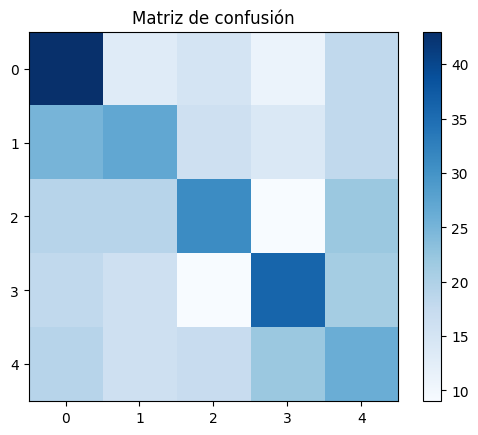

16/16 [==============================] - 1s 16ms/step - loss: 7.6288 - accuracy: 0.3260
Pérdida (Loss): 7.628774642944336
Precisión (Accuracy): 0.32600000500679016


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Cargar el modelo preentrenado
base_model = ResNet50(weights='imagenet', include_top=False)

# Añadir nuevas capas al final
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(100, activation='softmax')(x)

# Crear el nuevo modelo
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Cargar el dataset CIFAR100
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

# Seleccionar solo las clases 2, 11, 35, 46, 98
selected_classes = [2, 11, 35, 46, 98]
indices_train = np.isin(y_train, selected_classes).flatten()
indices_test = np.isin(y_test, selected_classes).flatten()

x_train, y_train = x_train[indices_train], y_train[indices_train]
x_test, y_test = x_test[indices_test], y_test[indices_test]

# Convertir las etiquetas a codificación one-hot
y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)

# Entrenar el modelo
model.fit(x_train, y_train, epochs=300, verbose=1)

# Realizar predicciones
y_pred = model.predict(x_test)

# Convertir las probabilidades en etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertir las etiquetas one-hot en etiquetas de clase
y_test_classes = np.argmax(y_test, axis=1)

# Mostrar la matriz de confusión
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de confusión')
plt.colorbar()
plt.show()

# Calcular la precisión y la pérdida en el conjunto de prueba
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Pérdida (Loss): {loss}")
print(f"Precisión (Accuracy): {accuracy}")


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Cargar el modelo preentrenado
base_model = ResNet50(weights='imagenet', include_top=False)

# Añadir nuevas capas al final
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Añadir regularización
predictions = Dense(100, activation='softmax')(x)

# Crear el nuevo modelo
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Cargar el dataset CIFAR100
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

# Seleccionar solo las clases 2, 11, 35, 46, 98
selected_classes = [2, 11, 35, 46, 98]
indices_train = np.isin(y_train, selected_classes).flatten()
indices_test = np.isin(y_test, selected_classes).flatten()

x_train, y_train = x_train[indices_train], y_train[indices_train]
x_test, y_test = x_test[indices_test], y_test[indices_test]

# Convertir las etiquetas a codificación one-hot
y_train = tf.keras.utils.to_categorical(y_train, num_classes=100)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=100)

# Crear un generador de datos para el aumento de datos
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

# Ajustar la tasa de aprendizaje
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# Entrenar el modelo
model.fit(datagen.flow(x_train, y_train, batch_size=32),
          steps_per_epoch=x_train.shape[0] // 64,
          epochs=300,
          verbose=2,
          validation_data=(x_test, y_test),
          callbacks=[learning_rate_reduction])

# Calcular la precisión y la pérdida en el conjunto de prueba
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Pérdida (Loss): {loss}")
print(f"Precisión (Accuracy): {accuracy}")

Epoch 1/300
39/39 - 7s - loss: 5.2718 - accuracy: 0.2035 - val_loss: 2.6145 - val_accuracy: 0.2620 - lr: 0.0010 - 7s/epoch - 175ms/step
Epoch 2/300
39/39 - 1s - loss: 3.9863 - accuracy: 0.2636 - val_loss: 2.1223 - val_accuracy: 0.3100 - lr: 0.0010 - 1s/epoch - 27ms/step
Epoch 3/300
39/39 - 1s - loss: 3.3812 - accuracy: 0.2721 - val_loss: 2.3606 - val_accuracy: 0.2880 - lr: 0.0010 - 1s/epoch - 27ms/step
Epoch 4/300
39/39 - 1s - loss: 3.0653 - accuracy: 0.2877 - val_loss: 2.0337 - val_accuracy: 0.3120 - lr: 0.0010 - 1s/epoch - 31ms/step
Epoch 5/300
39/39 - 1s - loss: 2.7197 - accuracy: 0.3101 - val_loss: 1.9801 - val_accuracy: 0.2960 - lr: 0.0010 - 1s/epoch - 31ms/step
Epoch 6/300
39/39 - 1s - loss: 2.5651 - accuracy: 0.3189 - val_loss: 1.8790 - val_accuracy: 0.3340 - lr: 0.0010 - 1s/epoch - 31ms/step
Epoch 7/300
39/39 - 1s - loss: 2.4551 - accuracy: 0.3238 - val_loss: 1.8618 - val_accuracy: 0.3240 - lr: 0.0010 - 1s/epoch - 37ms/step
Epoch 8/300
39/39 - 1s - loss: 2.3087 - accuracy: 0.31

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Cargar el modelo preentrenado
base_model = ResNet50(weights='imagenet', include_top=False)

# Añadir nuevas capas al final
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Añadir regularización
predictions = Dense(100, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Añadir regularización L2

# Crear el nuevo modelo
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Cargar el dataset CIFAR100
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

# Seleccionar solo las clases 2, 11, 35, 46, 98
selected_classes = [2, 11, 35, 46, 98]
indices_train = np.isin(y_train, selected_classes).flatten()
indices_test = np.isin(y_test, selected_classes).flatten()

x_train, y_train = x_train[indices_train], y_train[indices_train]
x_test, y_test = x_test[indices_test], y_test[indices_test]

# Convertir las etiquetas a codificación one-hot
y_train = tf.keras.utils.to_categorical(y_train, num_classes=100)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=100)

# Crear un generador de datos para el aumento de datos
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

# Ajustar la tasa de aprendizaje y parada temprana
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

# Entrenar el modelo
model.fit(datagen.flow(x_train, y_train, batch_size=32),
          steps_per_epoch=x_train.shape[0] // 64,
          epochs=300,
          verbose=2,
          validation_data=(x_test, y_test),
          callbacks=[learning_rate_reduction, early_stopping])

# Calcular la precisión y la pérdida en el conjunto de prueba
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f"Pérdida (Loss): {loss}")
print(f"Precisión (Accuracy): {accuracy}")

Epoch 1/300


1/1 [==============================] - 1s 932ms/step


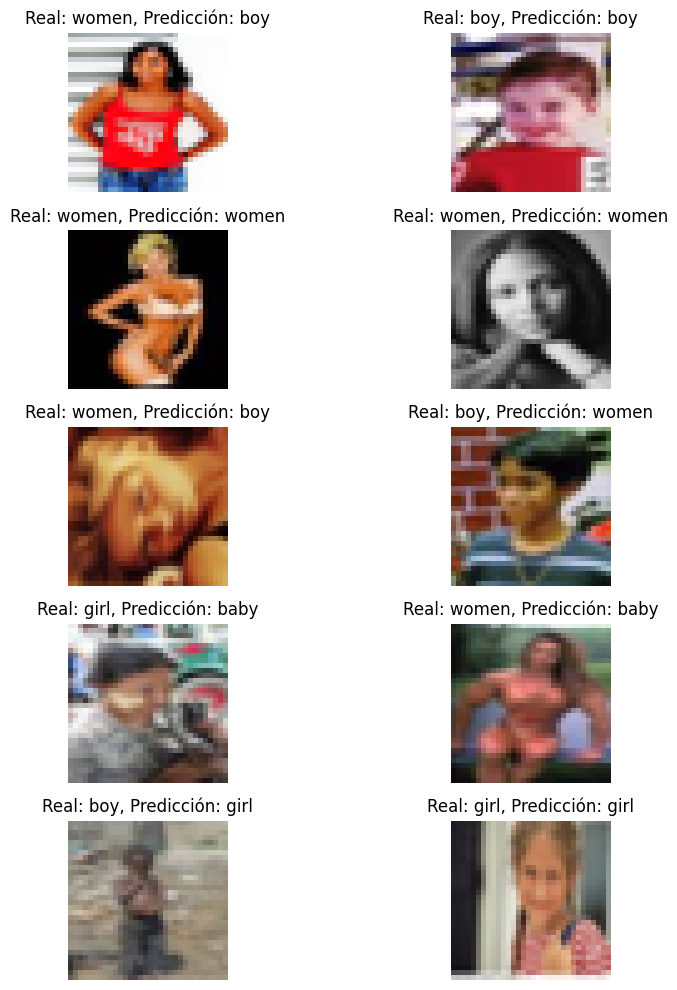

In [22]:
import matplotlib.pyplot as plt

# Mapeo de las clases a sus respectivas etiquetas
class_mapping = {2: 'baby', 11: 'boy', 35: 'girl', 46: 'men', 98: 'women'}

# Seleccionar un subconjunto de imágenes
indices = np.random.choice(range(len(x_test)), size=10)
x_subset = x_test[indices]
y_subset = y_test_classes[indices]

# Realizar predicciones
y_pred_subset = model.predict(x_subset)
y_pred_classes_subset = np.argmax(y_pred_subset, axis=1)

# Mostrar las imágenes con las etiquetas reales y las predicciones
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(x_subset[i])
    plt.title(f"Real: {class_mapping[y_subset[i]]}, Predicción: {class_mapping[y_pred_classes_subset[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()